<h1>Chapter 07. Ensemble Learning and Random Forests.</h1>

<b>Ensemble Learning:</b></br>
Ensemble learning merges predictions from multiple models, harnessing their diversity to boost accuracy. It outperforms individual models by leveraging their collective insights.</br>
<b>Random Forests:</b></br>
Random Forests, an ensemble of decision trees, improves accuracy and tackles overfitting by incorporating randomness in data sampling and feature subsets during training. This approach enhances robustness across a variety of tasks.

<h2>Voting Classifiers</h2>

Voting classifiers combine predictions from multiple models to make decisions. They can be either hard (majority vote) or soft (highest summed probabilities). This ensemble technique improves overall performance and generalization.

In [1]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons


X, y = make_moons(n_samples=500, noise=0.30, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In hard voting, each classifier votes for a class, and the majority class is chosen.

In [2]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC


log_clf = LogisticRegression(solver='lbfgs', random_state=42)
rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)
svm_clf = SVC(gamma='scale', random_state=42)

voting_clf = VotingClassifier(
    estimators=[
        ('lr', log_clf),
        ('rf', rnd_clf),
        ('svc', svm_clf)
    ],
    voting='hard'
)
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression(random_state=42)),
                             ('rf', RandomForestClassifier(random_state=42)),
                             ('svc', SVC(random_state=42))])

In [3]:
from sklearn.metrics import accuracy_score


for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.864
RandomForestClassifier 0.896
SVC 0.896
VotingClassifier 0.912


In soft voting, the class with the highest summed probability across classifiers is selected.

In [4]:
log_clf = LogisticRegression(solver='lbfgs', random_state=42)
rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)
svm_clf = SVC(gamma='scale', probability=True, random_state=42)

voting_clf = VotingClassifier(
    estimators=[
        ('lr', log_clf),
        ('rf', rnd_clf),
        ('svc', svm_clf)
    ],
    voting='soft'
)
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression(random_state=42)),
                             ('rf', RandomForestClassifier(random_state=42)),
                             ('svc', SVC(probability=True, random_state=42))],
                 voting='soft')

In [5]:
from sklearn.metrics import accuracy_score


for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.864
RandomForestClassifier 0.896
SVC 0.896
VotingClassifier 0.92


<h3>Bagging and Pasting</h3>

Bagging, or Bootstrap Aggregating, is an ensemble learning technique where multiple instances of the same learning algorithm are trained on different random subsets of the training data. Each model independently makes predictions, and the final prediction is often the average (for regression) or majority vote (for classification) of these individual predictions. Bagging helps reduce variance and mitigate overfitting.

Pasting is a variation of bagging where models are trained on non-overlapping random subsets of the training data. Unlike bagging, the same instance is not sampled multiple times for different models. Pasting can be useful when working with large datasets where sampling without replacement is computationally expensive or when you want to explore different subsets of the data.

<h3>Bagging and Pasting in Scikit-Learn</h3>

`BaggingClassifier` in scikit-learn is an ensemble method for classification. It trains multiple instances of a base classifier on different subsets of the data, combining their predictions to enhance overall performance and robustness.

In [6]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier


bag_clf = BaggingClassifier(
    DecisionTreeClassifier(),  # DecisionTreeClassifier as the base estimator
    n_estimators=500,          # number of base estimators in the ensemble
    max_samples=100,           # number of samples drawn for each base estimator
    bootstrap=True,            # whether to sample with replacement (bootstrap) or without (pasting)
    n_jobs=-1                  # use all available processors for parallel training
)
bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)

In [7]:
accuracy_score(y_test, y_pred)

0.912

In [8]:
tree_clf = DecisionTreeClassifier(random_state=42)
tree_clf.fit(X_train, y_train)
y_pred_tree = tree_clf.predict(X_test)

In [9]:
accuracy_score(y_test, y_pred_tree)

0.856

Plotting a single Decision Tree versus a bagging ensemble of 500 trees

In [10]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import numpy as np


def plot_decision_boundary(clf, X, y, axes=[-1.5, 2.45, -1, 1.5], alpha=0.5, contour=True):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[0], axes[1], 100)
    
    x1, x2 = np.meshgrid(x1s, x2s)

    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)

    custom_cmap = ListedColormap(['#fafab0', '#9898ff', '#a0faa0'])
    plt.contourf(
        x1,
        x2,
        y_pred,
        alpha=0.3,
        cmap=custom_cmap
    )

    if contour:
        custom_cmap2 = ListedColormap(['#7d7d58', '#4c4c7f', '#507d50'])
        plt.contour(
            x1,
            x2,
            y_pred,
            alpha=0.8,
            cmap=custom_cmap2
        )
    plt.plot(
        X[:, 0][y == 0],
        X[:, 1][y == 0],
        'yo',
        alpha=alpha
    )
    plt.plot(
        X[:, 0][y == 1],
        X[:, 1][y == 1],
        'bs',
        alpha=alpha
    )
    plt.axis(axes)
    plt.xlabel(r'$x_1$', fontsize=18)
    plt.ylabel(r'$x_2$', fontsize=18, rotation=0)
    plt.grid(True)

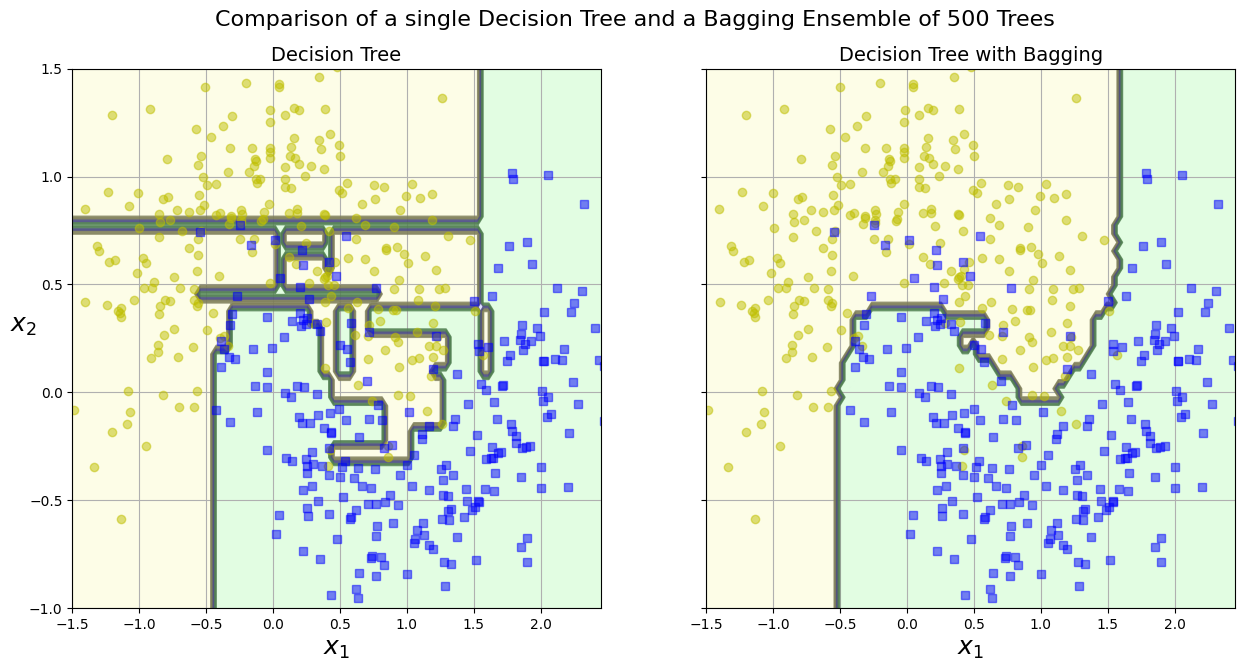

In [11]:
fig, axes = plt.subplots(ncols=2, figsize=(15, 7), sharey=True)
plt.sca(axes[0])
plot_decision_boundary(clf=tree_clf, X=X, y=y)
plt.title('Decision Tree', fontsize=14)

plt.sca(axes[1])
plot_decision_boundary(clf=bag_clf, X=X, y=y)
plt.title('Decision Tree with Bagging', fontsize=14)
plt.ylabel('')

plt.figtext(
    0.5,
    0.95,
    'Comparison of a single Decision Tree and a Bagging Ensemble of 500 Trees',
    ha='center',
    va='center',
    fontsize=16
)
plt.show()

<h3>Out-of-Bag evaluation</h3>

Out-of-bag (OOB) evaluation in ensemble learning assesses model performance using instances not included in the training set of individual trees, serving as an unbiased validation set for estimating generalization error.

In [12]:
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(),
    n_estimators=500,
    bootstrap=True,
    n_jobs=-1,
    oob_score=True,  # set up to request an automatic post-training OOB assessment
)
bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)

In [13]:
bag_clf.oob_score_

0.8933333333333333

In [14]:
accuracy_score(y_test, y_pred)

0.896

In [15]:
bag_clf.oob_decision_function_[:20]  # let's reduce output to 20

array([[0.40101523, 0.59898477],
       [0.38383838, 0.61616162],
       [1.        , 0.        ],
       [0.        , 1.        ],
       [0.        , 1.        ],
       [0.06806283, 0.93193717],
       [0.37435897, 0.62564103],
       [0.01069519, 0.98930481],
       [0.99481865, 0.00518135],
       [0.98863636, 0.01136364],
       [0.81355932, 0.18644068],
       [0.00568182, 0.99431818],
       [0.7826087 , 0.2173913 ],
       [0.85869565, 0.14130435],
       [0.97674419, 0.02325581],
       [0.05464481, 0.94535519],
       [0.        , 1.        ],
       [0.97435897, 0.02564103],
       [0.93085106, 0.06914894],
       [0.99462366, 0.00537634]])

<h2>Random Forests</h2>

`RandomForestClassifier` is a scikit-learn tool for classification using the random forest algorithm. It builds multiple decision trees, introducing randomness for improved robustness. Widely used for classification tasks, especially with complex or high-dimensional data.

In [16]:
from sklearn.ensemble import RandomForestClassifier


rnd_clf = RandomForestClassifier(
    n_estimators=500,
    max_leaf_nodes=16,  # limit each tree to a max of 16 nodes
    n_jobs=-1,
)
rnd_clf.fit(X_train, y_train)
y_pred_rf = rnd_clf.predict(X_test)

A Random Fores is a equivalent to a Bag of Decision Trees

In [17]:
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(
        splitter='random',  # introduces randomness to the feature selection for each split
        max_leaf_nodes=16
    ),
    n_estimators=500,
    max_samples=1.0,
    bootstrap=True,
    n_jobs=-1
)
bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)

In [18]:
np.sum(y_pred == y_pred_rf) / len(y_pred)  # very similar predictions

1.0

<h3>Extremely Randomized Trees</h3>

Extremely Randomized Trees, also known as Extra Trees, is an ensemble learning method that builds decision trees with an added level of randomness. Unlike traditional Random Forests, it selects random thresholds for node splits, resulting in an extra layer of diversification and potentially improved generalization in classification tasks.

`ExtraTreesClassifier` in scikit-learn is an implementation of Extremely Randomized Trees. It constructs a forest of decision trees with random feature selection and node splitting. This classifier is particularly useful for classification tasks, offering enhanced randomness to mitigate overfitting and handle complex datasets effectively.

<h3>Feature Importance</h3>

In [19]:
from sklearn.datasets import load_iris


iris = load_iris()

rnd_clf = RandomForestClassifier(
    n_estimators=500
)
rnd_clf.fit(iris['data'], iris['target'])

for name, score in zip(iris['feature_names'], rnd_clf.feature_importances_):
    print(f"Feature {name} has an importance of{score * 100: .2f}%")

Feature sepal length (cm) has an importance of 9.81%
Feature sepal width (cm) has an importance of 2.36%
Feature petal length (cm) has an importance of 45.55%
Feature petal width (cm) has an importance of 42.28%
